## Componentes de una Serie Temporal

Una serie temporal se compone principalmente de 3 componentes: tendencia, estacionalidad y ruido. En este cuaderno, echaremos un vistazo a los componentes de  de una serie de tiempo, centrándonos en cómo descomponer un serie temporal de forma automatizada. 

### Tendencia
- Cuando hablamos de tendencia, nos referimos a cómo los datos de la serie temporal aumentan o disminuyen en el tiempo -  ¿está aumentando (disminuyendo) con el tiempo? En esos casos, la serie temporal es de tendencia alcista o bajista, y ambas no son estacionarias.

### Estacionalidad
- La estacionalidad se refiere a la existencia de un patrón periódico o cíclico repetitivo con intervalos regulares dentro de una serie. El patrón está dentro de un período de tiempo fijo y se repite a intervalos regulares. Puede haber oscilaciones hacia arriba o hacia abajo, pero continúa repitiéndose durante un período fijo de tiempo como en un ciclo. La ciclicidad podría repetirse pero no tiene un período fijo.

### Ruido
- En general, el ruido capta las irregularidades o la variación aleatoria de la serie. Puede tener eventos erráticos o simplemente una variación aleatoria. Tiene una duración corta. Es difícil de predecir debido a su ocurrencia errática.

In [1]:


import pandas as pd
from matplotlib import pyplot as plt # required for decomposition
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white
# SSL to overcome problem with ssl whn applying pd.read_csv()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams


rcParams['figure.figsize'] = 15, 12

plt.style.use('seaborn-v0_8')




## Modelado de Series Temporales



In [2]:

link_pax = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

df_pax =  pd.read_csv(link_pax, parse_dates = ['Month'], index_col = 'Month')
df_pax.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# Hay estacionalidad porque repite el mismo patrón
px.line(df_pax)

In [4]:
# ¿Cómo reducimos la estacionalidad?
df_pax = df_pax[['Passengers']]
df_pax['previous_year'] = df_pax['Passengers'].shift(12) # 'shift' nos permite poner una predicción previa del año anterior. El 12 indica el número de filas que tienes que considerar para tener el dato.
display(df_pax.head(15))
px.line(df_pax) # Si pintamos ambas informaciones las series son muy similares

,Passengers,previous_year
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
1949-06-01,135,NaN
1949-07-01,148,NaN
1949-08-01,148,NaN
1949-09-01,136,NaN


### Modelo aditivo

Un modelo aditivo es lineal  $y(t) = Nivel + Tendencia + Estacionalidad + Ruido$

Es útil cuando las variaciones alrededor de la tendencia no varían con el nivel de la serie temporal. Los componentes se suman.

Para descomponer una serie temporal automáticamente usando `seasonal_decompose()`



#### Decomposición de Series Temporales - Modelo Aditivo

In [5]:
result = seasonal_decompose(df_pax['Passengers'], model = 'additive', period = 12) # variable que queremos descomponer, tipo de modelo y períodos
result # El modelo multiplicativo es menos restrictivo. Normalmente se suele ver más

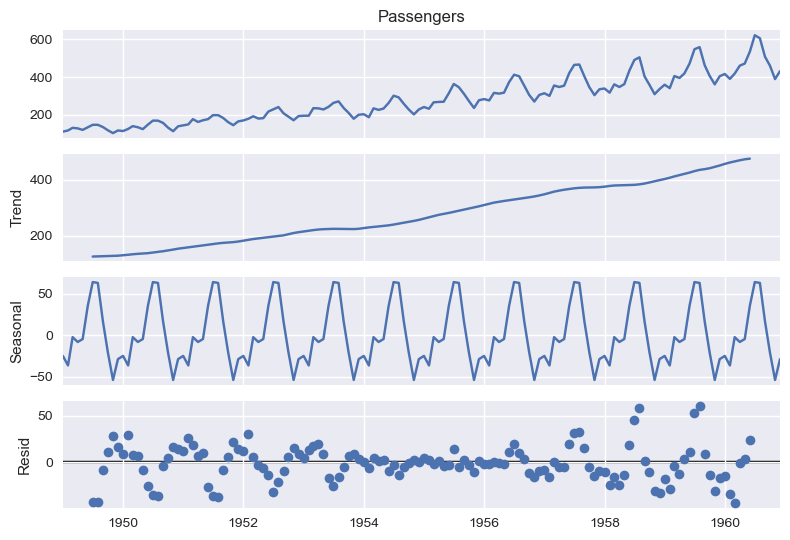

In [6]:
result.plot()
plt.show()

### Modelo Multipilcativo

El modelo multiplicativo no es lineal:  $y(t) = Nivel * Tendencia * Estacionalidad *  Ruido$

Una estacionalidad no lineal tiene una frecuencia y/o amplitud creciente o decreciente a lo largo del tiempo.
Es útil cuando la tendencia es proporcional al nivel de la serie temporal. Los componentes se multiplican entre sí.

#### Decomposición de Series Temporales - Modelo Multiplicativo

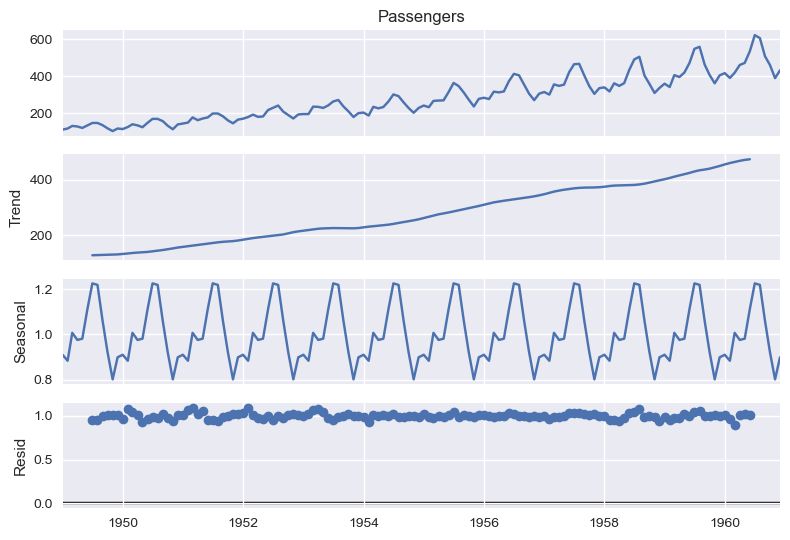

In [8]:
result = seasonal_decompose(df_pax['Passengers'], model='multiplicative', period=12)
result.plot()
plt.show()
# el uno es el mismo que el anterior, el dos es la tendencia, tercer componente la estacionalidad, cuarto el ruido

In [9]:
# Add the results to the data frame

df_pax['observed'] = result.observed
df_pax['trend'] = result.trend
df_pax['seasonal'] = result.seasonal
df_pax['resid'] = result.resid
# La suma de trend, seasonal y resid debería de ser igual a 'observed'
df_pax.head(15)

,Passengers,previous_year,observed,trend,seasonal,resid
Month,,,,,,
1949-01-01,112,NaN,112.0,NaN,0.910230,NaN
1949-02-01,118,NaN,118.0,NaN,0.883625,NaN
1949-03-01,132,NaN,132.0,NaN,1.007366,NaN
1949-04-01,129,NaN,129.0,NaN,0.975906,NaN
1949-05-01,121,NaN,121.0,NaN,0.981378,NaN
1949-06-01,135,NaN,135.0,NaN,1.112776,NaN
1949-07-01,148,NaN,148.0,126.791667,1.226556,0.951664
1949-08-01,148,NaN,148.0,127.250000,1.219911,0.953401
1949-09-01,136,NaN,136.0,127.958333,1.060492,1.002220


In [10]:
px.line(df_pax, template = 'plotly_white')

## Autocorrelación y Autocorrelación Parcial



In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

In [12]:
# What is the autocorrelation of Passengers? 
df_pax_corr = df_pax['Passengers'].autocorr() # Calcular el índice de Pearson de la información presente con respecto al pasado
df_pax_corr

0.9601946480498524

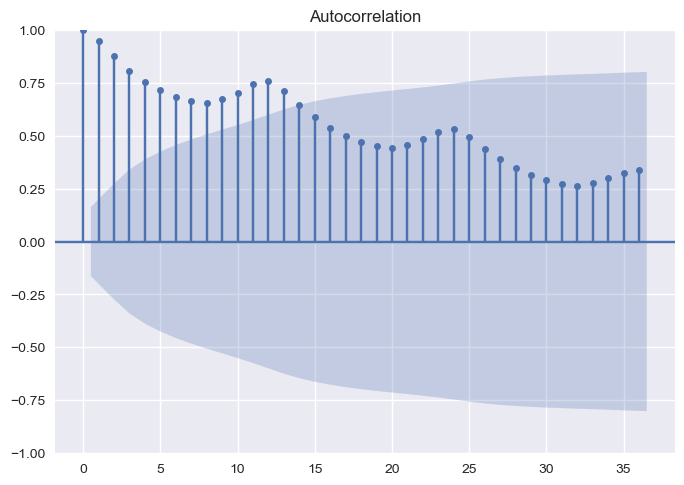

In [13]:
# Influencia del pasado que va decreciendo. 
plot_acf(df_pax['Passengers'], lags = 36)
plt.show()

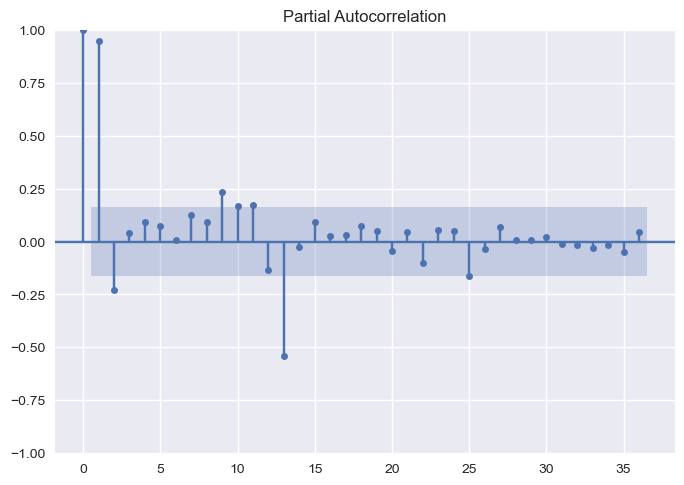

In [14]:
# Nos da una imagen individualizada de cada uno de los retardos
plot_pacf(df_pax['Passengers'], lags = 36)
plt.show()

## Procesos estacionarios

Podemos comprobar la estacionariedad estadísticamente mediante el test de Dickey-Fuller. Éste indica si la serie de tiempo tiene una raíz unitaria y, por lo tanto, no es estacionaria (es decir, la media y la varianza cambian con el tiempo)

La hipótesis nula del test es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). La hipótesis alternativa (que rechaza la hipótesis nula) es que la serie temporal es estacionaria.

⚡ **Nota rápida sobre los valores del p- value** ⚡

Interpretamos el resultado de la prueba de Dickey-Fulle utilizando el valor del p-value. Como en cualquier otro test inferencial, el p-value indica la probabilidad de obtener los resultados observados bajo el supuesto de que la hipótesis nula sea cierta. En otras palabras, indica la probabilidad de que los resultados se obtengan por casualidad. Si el p-value está por debajo de cierto umbral o probabilidad (llamado intervalo de confianza), generalmente 0.05 (aunque puede ser otro según el caso), significa que hay evidencia suficiente para sustentar que los resultados no son del todo aleatorios y por lo tanto se puede rechazar la hipótesis nula.


**Hipótesis nula (H0)**: Si no se rechaza, indica que hay evidencia que sugiere que la serie de tiempo tiene una raíz unitaria y, por lo tanto, no es estacionaria. Tiene una estructura dependiente del tiempo.

**Hipótesis alternativa (H1)**: Si se rechaza la hipótesis nula, sugiere que la serie de tiempo no tiene raíz unitaria, lo que significa que es estacionaria. No tiene una estructura dependiente del tiempo.

- **p-value > 0.05**: No se rechaza la hipótesis nula (H0), los datos tienen raíz unitaria y no son estacionarios.
- **p-value <= 0.05**: Rechaza la hipótesis nula (H0), el dato no tiene raíz unitaria y es estacionario.


Aunque es una buena referencia para determinar si nuestros datos son estacionarios, el test Dickey Fuller presenta algunas limitaciones como la asunción de que los datos siguen una distribución normal. En la realidad esto es un supuesto poco habitual por lo que es necesario recurrir a tests que alivien este supuesto. Por ejemplo el test de Mann - Kendall es un test no-paramétrico que nos ayuda a detectar si existen tendencias cuando los datos no se distribuyen de forma normal. 

In [ ]:
result = adfuller(df_pax['Passengers'])
print('p-value of the Dickey-Fuller test: %f' % result[1]) 

In [ ]:
# Sources: 
#        https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html
#        https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/tree/main/notebooks/Chapter07



def check_trend(time_series, alpha=0.05):
    """
    Perform the Mann-Kendall test for stationarity on a time series.

    Parameters:
    - time_series: pandas Series or DataFrame column containing the time series data.
    - alpha: Significance level for the test.
    - The null hypothesis is that there is no trend.

    Returns:
    - result: pymannkendall test result object.
    """
    result = mk.original_test(time_series, alpha=alpha)
    return result

In [ ]:
check_trend(df_pax['Passengers'], alpha=0.05)

<font color='orange'> 

### Ejercicio

Carga el archivo en el enlace a continuación y crea un índice de fecha. Descompón la serie de tiempo resultante. Calcula el ACF y el PACF y determina si el proceso es estacionario.





</b> </font>

In [15]:
link = 'https://raw.githubusercontent.com/oliverguhr/transformer-time-series-prediction/master/daily-min-temperatures.csv'

## Métricas de error (evaluación)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
from math import sqrt

Estas métricas son importantes para evaluar la calidad del modelo. Es importante elegir la mejor métrica para el problema en cuestión. Este [link](https://www.dataquest.io/blog/understanding-regression-error-metrics/) ofrece más detalles. Utilizamos el ejemplo que hemos usado en la descomposición de series temporales de secciones anteriores. 


In [ ]:
# Back to passengers dastaset

df = df_pax.copy()

df.head()

In [ ]:
# Decompose the time series 

result_decomp = seasonal_decompose(df['Passengers'], model='multiplicative')


In [ ]:
# Add the results of the decomposition to the dataframe

df['observed'] = result_decomp.observed
df['trend'] = result_decomp.trend
df['seasonal'] = result_decomp.seasonal
df['residual'] = result_decomp.resid


df.head()

Calculamos un modelo simple que utiliza únicamente la tendencia y el componente estacional para predecir el número de pasajeros. A continuación calculamos distintas métricas utilizando 

In [ ]:
df['estimated'] = df['trend'] + df['seasonal']
df_matrix = df[['Passengers', 'estimated']].copy()
df_matrix = df_matrix[df_matrix['estimated'].isna() == False]
df_matrix.head(5)

In [ ]:
px.line(df_matrix)

### Error Medio Absoluto (_Mean Absolute Error - MAE_)

In [ ]:
mean_absolute_error(y_pred = df_matrix['estimated'], y_true = df_matrix['Passengers']) 

### Error Medio Cuadrado (_Mean Squared Error - MSE_)

In [ ]:
mean_squared_error(y_pred = df_matrix['estimated'], y_true = df_matrix['Passengers']) 

### Error cuadrático medio (_Root Mean Squared Error - RMSE_)

In [ ]:
sqrt(mean_squared_error(y_pred = df_matrix['estimated'], y_true = df_matrix['Passengers']))

### R cuadrado (_R squared - R2_)

In [ ]:
r2_score(y_pred = df_matrix['estimated'], y_true = df_matrix['Passengers'])

### Error porcentual absoluto medio (_Mean Absolute Percentage Error - MAPE_)

In [ ]:
mean_absolute_percentage_error(y_pred = df_matrix['estimated'], y_true = df_matrix['Passengers'])